## Exploring Gender Bias in Ratings

The following section addresses the question of whether there is a relationship between gender and ratings. 

Due to the nature of the library used to perform the analysis, gender will be assumed to be a binary gender system (male and female). This does not reflect our beliefs about gender identity.

The null hypothesis states that the difference in ratings between males and female authors is due to chance only. The alternative hypothesis states that the difference is due to some other factors and not chance alone. 

The library [gender-guesser](https://pypi.org/project/gender-guesser/) takes in first names as input and outputs 4 outcomes: `(1) unknown (name not found)`, `(2) andy (androgynous)`, `(3) male`, `(4) female`, `(5) mostly_male`, `(6) mostly_female`. 

`Andy` is assigned when the probability of being male is equal to the probability of being female. `Unknown` is assigned to names that weren't found in the database.

## Installation

* In Jupyter notebook

!pip install gender-guesser

* In the terminal

pip install gender-guesser

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from scipy.stats import ttest_ind # statistics
import gender_guesser.detector as gender # gender analysis

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')

In [2]:
# create a dataframe from the authors json file. This file contains authors data that goes beying our book genre data
authors = pd.read_json('../data/goodreads_book_authors.json', lines = True)

Since we have some repeated authors in the dataset, we will group by name and take the average of the rating for each author to perform our analysis. The average will be stored in a new column named 'rating'.

In [4]:
authors['rating'] = authors.groupby('name')['average_rating'].transform('mean')

In [5]:
authors.head()

,average_rating,author_id,text_reviews_count,name,ratings_count,rating
0,3.98,604031,7,Ronald J. Fields,49,3.98
1,4.08,626222,28716,Anita Diamant,546796,4.08
2,3.92,10333,5075,Barbara Hambly,122118,3.92
3,3.68,9212,36262,Jennifer Weiner,888522,3.68
4,3.82,149918,96,Nigel Pennick,1740,3.82


In [6]:
# get authors' first name
first_names = authors['name'].str.split(' ',expand=True)[0]

In [7]:
# exact gender using gender-guesser
d = gender.Detector(case_sensitive=False)
#create list of genders from names
genders = [d.get_gender(name) for name in first_names]

In [8]:
# create a pandas series for gender. We will convert mostly_female and mostly_male to female and male respectively
genders = pd.Series([x.replace('mostly_female','female').replace('mostly_male','male') for x in genders])

In [9]:
# calculate the percentage of males and females represented in the dataset

gender_proportions = genders.value_counts().to_frame()
gender_proportions.reset_index(inplace = True)

gender_proportions.columns = ['gender', 'count']
total = sum (gender_proportions['count'])

gender_proportions['percentage'] = gender_proportions['count']/total*100

gender_proportions

,gender,count,percentage
0,male,360745,43.487931
1,female,284892,34.343826
2,unknown,172032,20.738515
3,andy,11860,1.429727


In [10]:
#create a column for gender in the authors dataframe
authors['Gender'] = genders

# create a rating array for males and females for plotting purposes
male_scores = authors[authors['Gender'] == 'male']['rating'].values
female_scores= authors[authors['Gender'] == 'female']['rating'].values

## Plotting

Now, we are ready to plot the distribution of ratings for male vs. female authors

In [18]:
pal = sns.color_palette('pastel')
pal.as_hex()

['#a1c9f4',
 '#ffb482',
 '#8de5a1',
 '#ff9f9b',
 '#d0bbff',
 '#debb9b',
 '#fab0e4',
 '#cfcfcf',
 '#fffea3',
 '#b9f2f0']

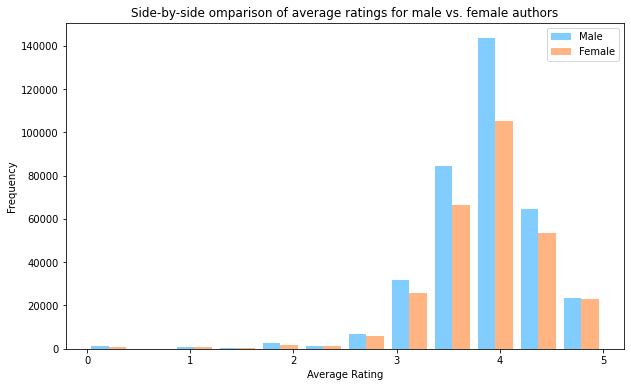

In [19]:
# set the figure size
plt.rcParams['figure.figsize'] = [10, 6]

# Assign colors for gender
colors = ['#82CDFF',  '#FFB482'] 
names = ['Male', 'Female']
         
# Make the histogram using a list of lists
plt.hist([male_scores,female_scores], bins = int(180/15),
         color = colors, label=names)

# Plot formatting

plt.legend()
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.title('Side-by-side omparison of average ratings for male vs. female authors')
plt.savefig('../visualizations/gender-ratings.svg', format='svg', dpi=1200)

In [5]:
# basic exploration of the dataset
authors.shape
authors['name'].value_counts()

Phil Noto                  22
Marco Checchetto            9
Ibrahim al-Koni             8
Mark Brooks                 7
                            5
                           ..
rD ywry                     1
Andrew   Walsh              1
Biruta Akerbergs Hansen     1
Nguyen Huy Hai              1
Charles Sawyer              1
Name: name, Length: 825851, dtype: int64

In [54]:
pal = sns.color_palette("Set2")
pal.as_hex()

['#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3']

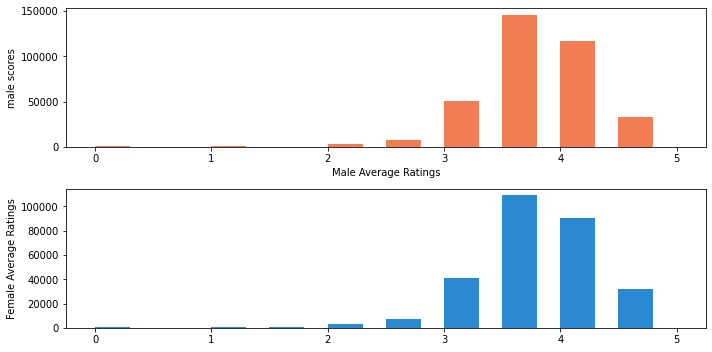

In [14]:
fig, axes = plt.subplots(2,1)

axes[0].hist(male_scores, color='#f27d52', bins = 10, width = 0.3)
axes[0].set_xlabel('Male Average Ratings')
# Make the y-axis label, ticks and tick labels match the line color.
axes[0].set_ylabel('male scores')

axes[1].hist(female_scores, color='#2a89d1', bins = 10, width = 0.3)
axes[1].set_ylabel('Female Average Ratings')

fig.tight_layout()

## Making sense of the results

In order to determine whether the difference in ratings between male and female authors is significant, we need to determine the type of statistical tool to use. Since we are looking at differences between 2 groups, a student t-test or Kolmogorov-Smirnov test stand out as possible choices.

An independent student t-test works best with normally distributed data. The KS Test on the other hand,is a non-parametric and distribution-free test. It makes no assumption about the distribution of data.

Let's examine the distributed of ratings:

Rejecting null hypothesis - data does not come from a normal distribution (p=0.0)


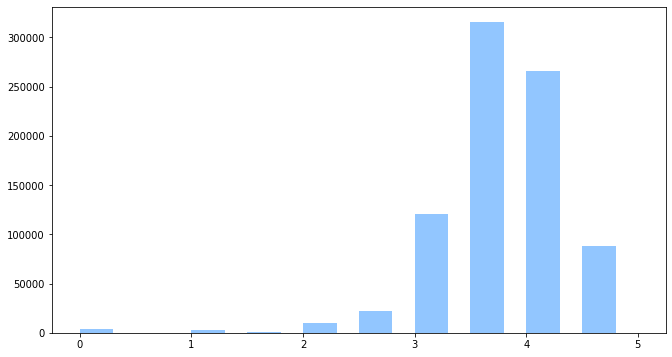

In [42]:
plt.hist(authors['rating'], bins = 10, width = 0.3)

W, p_value = scipy.stats.shapiro(authors["rating"])

if p_value < 0.05:
    print("Rejecting null hypothesis - data does not come from a normal distribution (p=%s)"%p_value)
else:
    print("Cannot reject null hypothesis (p=%s)"%p_value)

It appears that our sample isn't normally distributed. Based on this finding, we will go ahead and use the KS test to examine the difference in the two groups(male authors vs. female authors).

## Running Kolmogorov-Smirnov test

In [43]:
male_scores = authors[authors['Gender'] == 'male']['rating'].values
female_scores = authors[authors['Gender'] == 'female']['rating'].values

scipy.stats.ks_2samp(male_scores, female_scores)

KstestResult(statistic=0.02653304279961255, pvalue=8.727076134911029e-98)

## Interpreting the results

The null hypothesis of the KS test is that both groups were sampled from populations with identical distributions. It tests for any violation of that null hypothesis -- different medians, different variances, or different distributions. It answers the question of whether the two samples were randomly sampled from identical populations and if so what is the probability that the two cumulative frequency distributions would be as far apart as observed.  

The D statistic represents the absolute max distance between the CDFs of the two samples. The closer this number is to 0 the more likely it is that the two samples were drawn from the same distribution.

Given our much lower than 0 D statistic and extremely low p-value, we reject the null hypothesis that the two samples were drawn from the same distribution. It appears as though there is bias in rating for male vs. female authors, with male authors being given higher overall ratings.